1. Use a multimodal LLM (such as GPT-4V, LLaVA, or FUYU-8b) to produce text summaries from images
2. Embed and retrieve image summaries with a reference to the raw image
3. Pass raw images and text chunks to a multimodal LLM for answer synthesis

In [ ]:
!pip install pdf2image
!pip install pytesseract
!apt install poppler-utils
!apt install tesseract-ocr
#
!pip install -U langchain openai chromadb langchain-experimental # (newest versions required for multi-modal)
#
# lock to 0.10.19 due to a persistent bug in more recent versions
!pip install "unstructured[all-docs]==0.10.19" pillow pydantic lxml pillow matplotlib tiktoken open_clip_torch torch

## Data Loading

In [6]:
import os
import shutil
os.mkdir("content")
!wget "https://www.getty.edu/publications/resources/virtuallibrary/0892360224.pdf"
shutil.move("0892360224.pdf","content")

--2024-01-02 06:07:31--  https://www.getty.edu/publications/resources/virtuallibrary/0892360224.pdf
Resolving www.getty.edu (www.getty.edu)... 99.84.191.61, 99.84.191.10, 99.84.191.85, ...
Connecting to www.getty.edu (www.getty.edu)|99.84.191.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 18838661 (18M) [application/pdf]
Saving to: ‘0892360224.pdf’

0892360224.pdf      100%[===================>]  17.97M  --.-KB/s    in 0.08s   

2024-01-02 06:07:31 (236 MB/s) - ‘0892360224.pdf’ saved [18838661/18838661]



'content/0892360224.pdf'

In [13]:
path = "content/"
#
file_name = os.listdir(path)
file_name

['0892360224.pdf']

In [14]:
path + file_name[0]

'content/0892360224.pdf'

In [15]:
# Extract images, tables, and chunk text
from unstructured.partition.pdf import partition_pdf

raw_pdf_elements = partition_pdf(
    filename=path + file_name[0],
    extract_images_in_pdf=True,
    infer_table_structure=True,
    chunking_strategy="by_title",
    max_characters=4000,
    new_after_n_chars=3800,
    combine_text_under_n_chars=2000,
    image_output_dir_path=path,
)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


yolox_l0.05.onnx:   0%|          | 0.00/217M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.47k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/115M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/46.8M [00:00<?, ?B/s]

Some weights of the model checkpoint at microsoft/table-transformer-structure-recognition were not used when initializing TableTransformerForObjectDetection: ['model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing TableTransformerForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TableTransformerForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


### Categorize text elements by type

In [16]:
tables = []
texts = []
for element in raw_pdf_elements:
    if "unstructured.documents.elements.Table" in str(type(element)):
        tables.append(str(element))
    elif "unstructured.documents.elements.CompositeElement" in str(type(element)):
        texts.append(str(element))

In [19]:
len(tables)

2

In [20]:
len(texts)

194

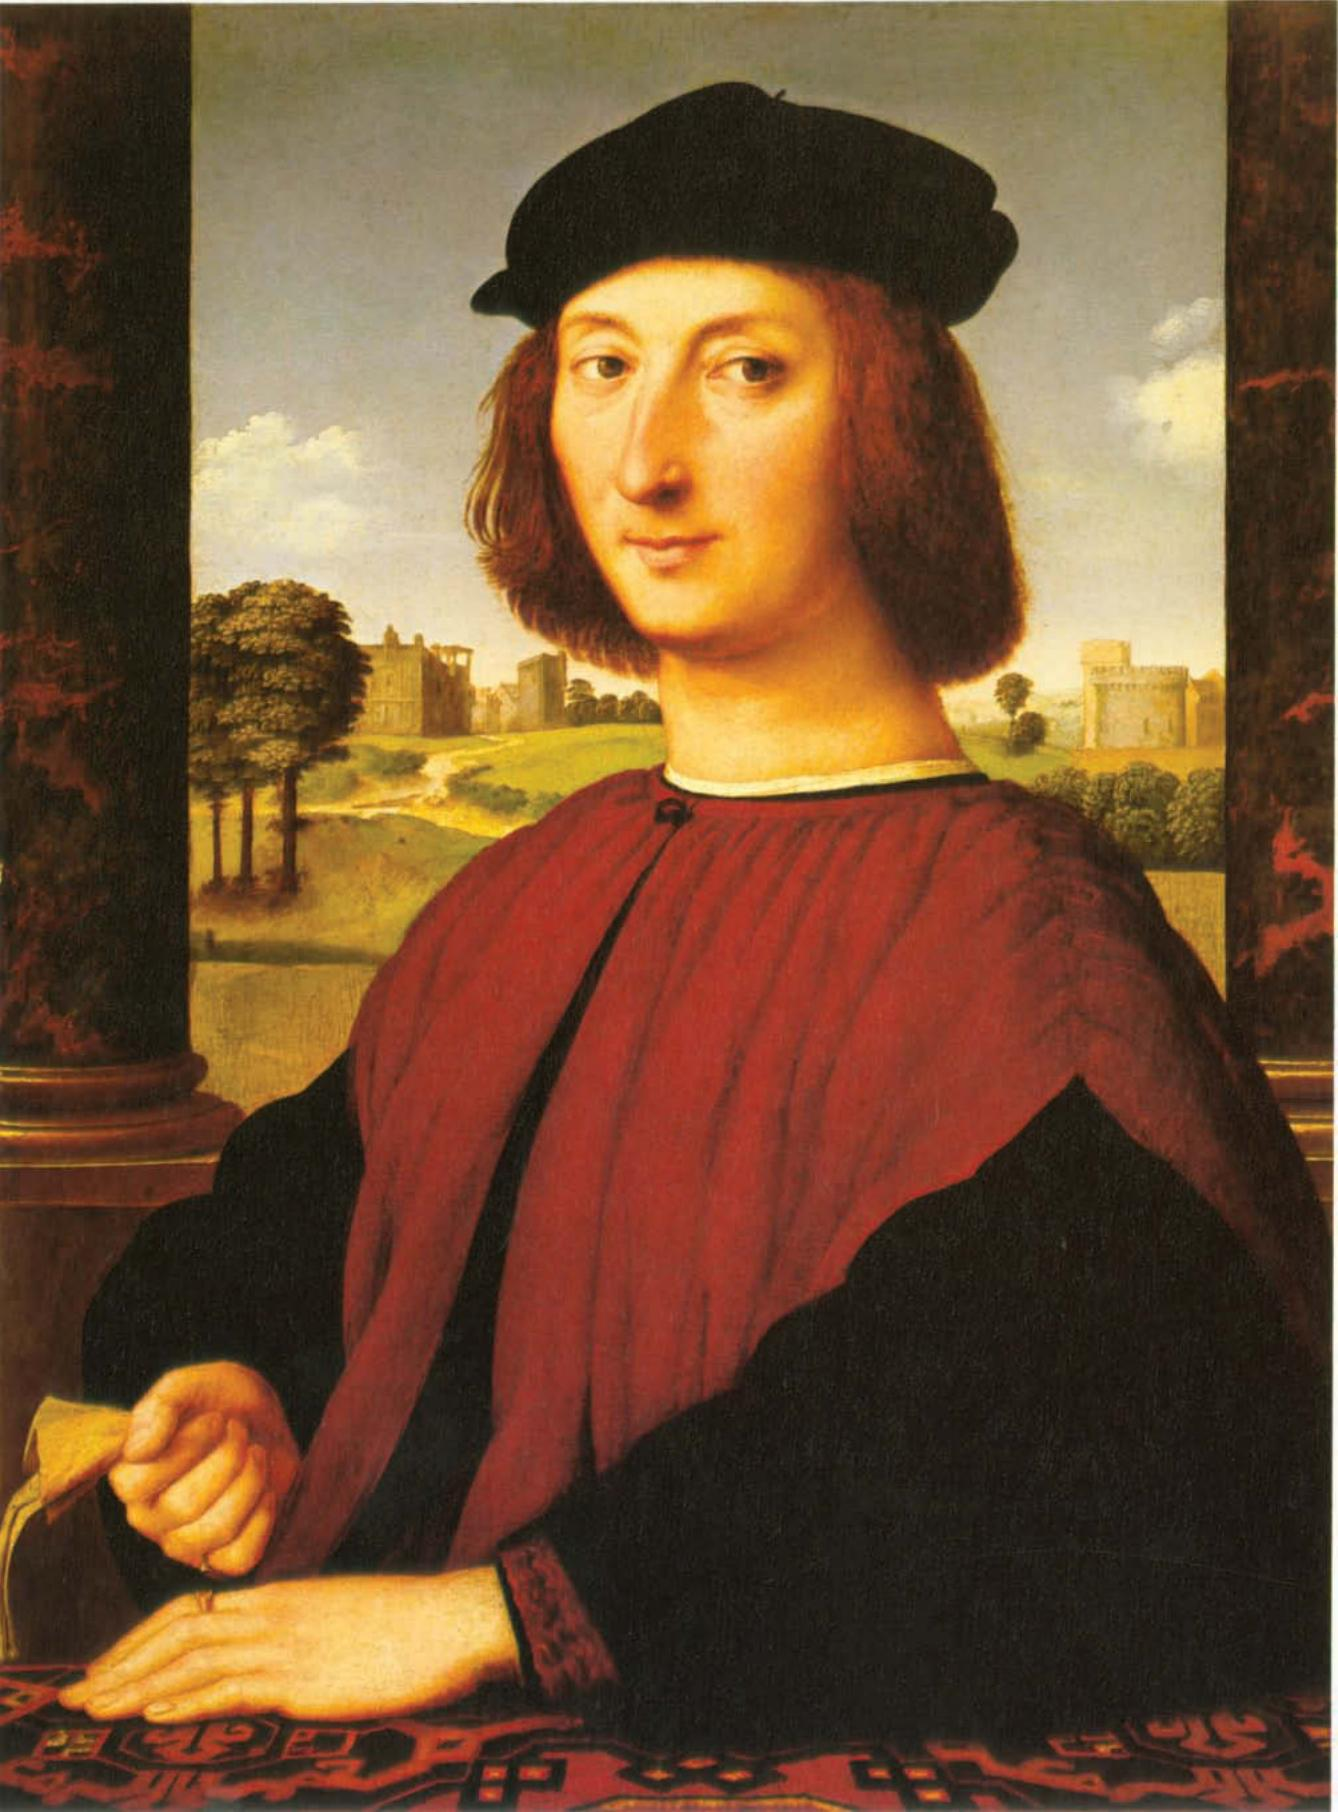

In [22]:
from PIL import Image
Image.open("content/figure-26-1.jpg")

## Multi-modal embeddings with our document

In [ ]:
import os
import uuid

import chromadb
import numpy as np
from langchain.vectorstores import Chroma
from langchain_experimental.open_clip import OpenCLIPEmbeddings
from PIL import Image as _PILImage

# Create chroma
vectorstore = Chroma(
    collection_name="mm_rag_clip_photos", embedding_function=OpenCLIPEmbeddings()
)

# Get image URIs with .jpg extension only
image_uris = sorted(
    [
        os.path.join(path, image_name)
        for image_name in os.listdir(path)
        if image_name.endswith(".jpg")
    ]
)

# Add images
vectorstore.add_images(uris=image_uris)

# Add documents
vectorstore.add_texts(texts=texts)

# Make retriever
retriever = vectorstore.as_retriever()

In [ ]:
# Helper functions
import base64
import io
from io import BytesIO

import numpy as np
from PIL import Image


def resize_base64_image(base64_string, size=(128, 128)):
    """
    Resize an image encoded as a Base64 string.

    Args:
    base64_string (str): Base64 string of the original image.
    size (tuple): Desired size of the image as (width, height).

    Returns:
    str: Base64 string of the resized image.
    """
    # Decode the Base64 string
    img_data = base64.b64decode(base64_string)
    img = Image.open(io.BytesIO(img_data))

    # Resize the image
    resized_img = img.resize(size, Image.LANCZOS)

    # Save the resized image to a bytes buffer
    buffered = io.BytesIO()
    resized_img.save(buffered, format=img.format)

    # Encode the resized image to Base64
    return base64.b64encode(buffered.getvalue()).decode("utf-8")


def is_base64(s):
    """Check if a string is Base64 encoded"""
    try:
        return base64.b64encode(base64.b64decode(s)) == s.encode()
    except Exception:
        return False


def split_image_text_types(docs):
    """Split numpy array images and texts"""
    images = []
    text = []
    for doc in docs:
        doc = doc.page_content  # Extract Document contents
        if is_base64(doc):
            # Resize image to avoid OAI server error
            images.append(
                resize_base64_image(doc, size=(250, 250))
            )  # base64 encoded str
        else:
            text.append(doc)
    return {"images": images, "texts": text}

from IPython.display import HTML, display


def plt_img_base64(img_base64):
    # Create an HTML img tag with the base64 string as the source
    image_html = f'<img src="data:image/jpeg;base64,{img_base64}" />'

    # Display the image by rendering the HTML
    display(HTML(image_html))

In [ ]:
from operator import itemgetter

from langchain.chat_models import ChatOpenAI
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnableLambda, RunnablePassthrough,RunnableParallel


def prompt_func(data_dict):
    # Joining the context texts into a single string
    formatted_texts = "\n".join(data_dict["context"]["texts"])
    messages = []

    # Adding image(s) to the messages if present
    if data_dict["context"]["images"]:
        image_message = {
            "type": "image_url",
            "image_url": {
                "url": f"data:image/jpeg;base64,{data_dict['context']['images'][0]}"
            },
        }
        messages.append(image_message)

    # Adding the text message for analysis
    text_message = {
        "type": "text",
        "text": (
            "As an expert art critic and historian, your task is to analyze and interpret images, "
            "considering their historical and cultural significance. Alongside the images, you will be "
            "provided with related text to offer context. Both will be retrieved from a vectorstore based "
            "on user-input keywords. Please use your extensive knowledge and analytical skills to provide a "
            "comprehensive summary that includes:\n"
            "- A detailed description of the visual elements in the image.\n"
            "- The historical and cultural context of the image.\n"
            "- An interpretation of the image's symbolism and meaning.\n"
            "- Connections between the image and the related text.\n\n"
            f"User-provided keywords: {data_dict['question']}\n\n"
            "Text and / or tables:\n"
            f"{formatted_texts}"
        ),
    }
    messages.append(text_message)

    return [HumanMessage(content=messages)]

In [ ]:
from google.colab import userdata


openai_api_key = userdata.get('OPENAI_API_KEY')

model = ChatOpenAI(temperature=0,
                   openai_api_key=openai_api_key,
                   model="gpt-4-vision-preview",
                   max_tokens=1024)

# RAG pipeline
chain = (
    {
        "context": retriever | RunnableLambda(split_image_text_types),
        "question": RunnablePassthrough(),
    }
    | RunnableParallel({"response":prompt_func| model| StrOutputParser(),
                      "context": itemgetter("context"),})
)

### Invoke RAG QA chain

In [ ]:
response = chain.invoke("hunting on the lagoon")
#
print(response['response'])
print(response['context'])

In [ ]:
plt_img_base64(response['context']['images'][0])